In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure GPU (if available)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU found and configured")
else:
    print("Running on CPU")

TensorFlow version: 2.10.0
Running on CPU


In [3]:
# Model parameters
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 20
LEARNING_RATE = 0.001

# CRITICAL: Ensure these class names match your folder structure exactly
class_names = ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature',
               'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi',
               'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos',
               'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']

print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")


Number of classes: 20
Classes: ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']


In [4]:
# Update this path to match your dataset location
DATASET_PATH = 'FinalDataSet'  # Change this to your actual dataset path

# Verify dataset exists
if not os.path.exists(DATASET_PATH):
    print(f"ERROR: Dataset path '{DATASET_PATH}' not found!")
    print("Please update DATASET_PATH to point to your dataset folder")
else:
    print(f"Dataset found at: {DATASET_PATH}")
    
    # List available folders
    folders = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
    print(f"Found {len(folders)} folders: {folders}")
    
    # Count images per class
    for folder in folders[:5]:  # Show first 5 classes
        folder_path = os.path.join(DATASET_PATH, folder)
        image_count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {folder}: {image_count} images")

Dataset found at: FinalDataSet
Found 20 folders: ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']
  burger: 300 images
  butter_naan: 278 images
  chai: 314 images
  chapati: 299 images
  chole_bhature: 344 images


In [5]:
# Data augmentation for training (helps prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to 0-1
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    shear_range=0.2,          # Random shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest',      # Fill strategy for new pixels
    validation_split=0.2      # Use 20% for validation
)

# No augmentation for validation data (only normalization)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

print("Data generators created successfully")

Data generators created successfully


In [6]:
# Create training data generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # One-hot encoded labels
    subset='training',
    shuffle=True,
    seed=42
)

# Create validation data generator
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
print(f"Validation steps: {validation_generator.samples // BATCH_SIZE}")
print(f"Class indices: {train_generator.class_indices}")


Found 4202 images belonging to 20 classes.
Found 1037 images belonging to 20 classes.
Training samples: 4202
Validation samples: 1037
Steps per epoch: 131
Validation steps: 32
Class indices: {'burger': 0, 'butter_naan': 1, 'chai': 2, 'chapati': 3, 'chole_bhature': 4, 'dal_makhani': 5, 'dhokla': 6, 'fried_rice': 7, 'idli': 8, 'jalebi': 9, 'kaathi_rolls': 10, 'kadai_paneer': 11, 'kulfi': 12, 'masala_dosa': 13, 'momos': 14, 'paani_puri': 15, 'pakode': 16, 'pav_bhaji': 17, 'pizza': 18, 'samosa': 19}


Sample training images:


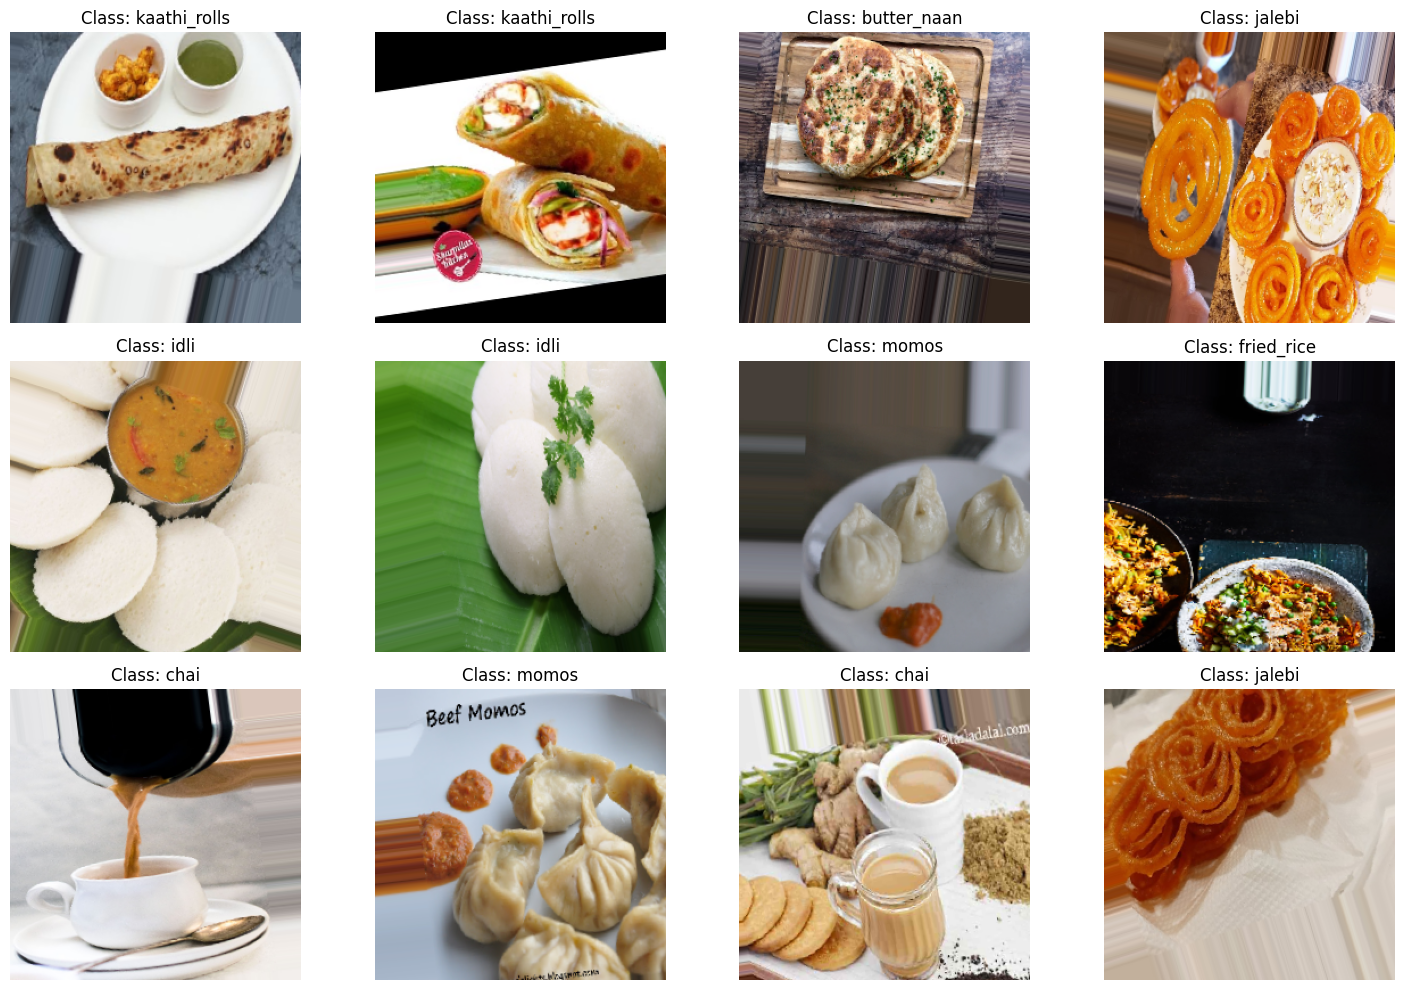

In [7]:
# Display a batch of training images
def show_batch(generator, class_names):
    batch_images, batch_labels = next(generator)
    
    plt.figure(figsize=(15, 10))
    for i in range(min(12, len(batch_images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(batch_images[i])
        
        # Get class name from one-hot encoded label
        class_idx = np.argmax(batch_labels[i])
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample training images:")
show_batch(train_generator, class_names)

In [8]:
def create_food_classifier_model():
    """
    Create an improved CNN model for food classification
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Global Average Pooling (alternative to Flatten)
        layers.GlobalAveragePooling2D(),
        
        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer - IMPORTANT: Use softmax for multi-class classification
        layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')
    ])
    
    return model

# Create the model
model = create_food_classifier_model()

# Display model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [9]:
# Compile model with appropriate optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print("Model compiled successfully!")
print(f"Total parameters: {model.count_params():,}")


Model compiled successfully!
Total parameters: 1,445,300


In [10]:
# Create callbacks for better training
callbacks = [
    # Save best model based on validation accuracy
    tf.keras.callbacks.ModelCheckpoint(
        'best_food_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    ),
    
    # Stop training if no improvement
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    
    # Reduce learning rate when plateauing
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    ),
    
    # Log training progress
    tf.keras.callbacks.CSVLogger('training_log.csv')
]

print("Callbacks configured")

Callbacks configured


In [11]:
print("Starting training...")
print(f"Training for {EPOCHS} epochs")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")

# Calculate steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Start training
start_time = datetime.now()

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
training_duration = end_time - start_time
print(f"\nTraining completed in: {training_duration}")


Starting training...
Training for 50 epochs
Batch size: 32
Learning rate: 0.001
Steps per epoch: 131
Validation steps: 32


Epoch 1/50
131/131 [==============================] - ETA: 0s - loss: 3.7218 - accuracy: 0.0923 - top_k_categorical_accuracy: 0.3679
Epoch 1: val_accuracy improved from -inf to 0.07520, saving model to best_food_model.h5
131/131 [==============================] - 415s 3s/step - loss: 3.7218 - accuracy: 0.0923 - top_k_categorical_accuracy: 0.3679 - val_loss: 3.7944 - val_accuracy: 0.0752 - val_top_k_categorical_accuracy: 0.2734 - lr: 0.0010
Epoch 2/50
131/131 [==============================] - ETA: 0s - loss: 3.1839 - accuracy: 0.1458 - top_k_categorical_accuracy: 0.4902
Epoch 2: val_accuracy improved from 0.07520 to 0.08594, saving model to best_food_model.h5
131/131 [==============================] - 467s 4s/step - loss: 3.1839 - accuracy: 0.1458 - top_k_categorical_accuracy: 0.4902 - val_loss: 4.6218 - val_accuracy: 0.0859 - val_top_k_categorical_accuracy: 0.3174 - lr: 0.0010
Epoch 3/50
131/131 [==============================] - ETA: 0s - loss: 2.8557 - accuracy: 0.1760 - top_k_categ

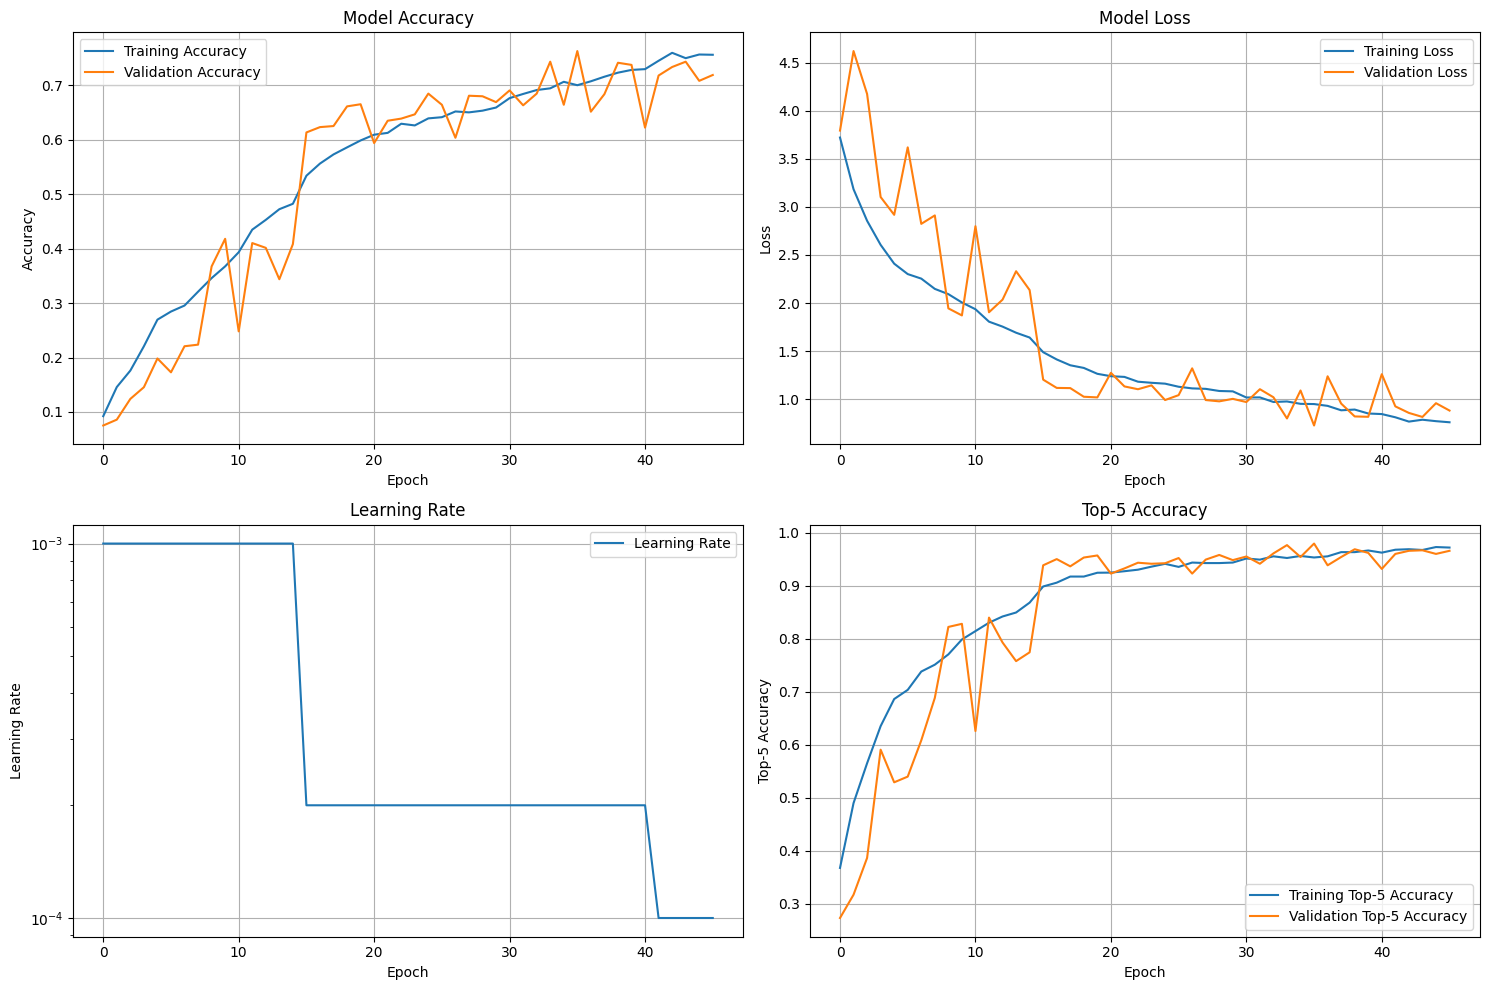


Final Training Accuracy: 0.7559
Final Validation Accuracy: 0.7188
Final Training Loss: 0.7592
Final Validation Loss: 0.8811


In [12]:
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs_range = range(len(history.history['accuracy']))
    
    # Plot training & validation accuracy
    ax1.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    ax1.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(epochs_range, history.history['loss'], label='Training Loss')
    ax2.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs_range, history.history['lr'], label='Learning Rate')
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.legend()
        ax3.grid(True)
        ax3.set_yscale('log')
    
    # Plot top-k accuracy (if available)
    if 'top_k_categorical_accuracy' in history.history:
        ax4.plot(epochs_range, history.history['top_k_categorical_accuracy'], label='Training Top-5 Accuracy')
        ax4.plot(epochs_range, history.history['val_top_k_categorical_accuracy'], label='Validation Top-5 Accuracy')
        ax4.set_title('Top-5 Accuracy')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Top-5 Accuracy')
        ax4.legend()
        ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

# Plot the training history
plot_training_history(history)


In [13]:
# Load the best model (saved by ModelCheckpoint callback)
try:
    best_model = tf.keras.models.load_model('best_food_model.h5')
    print("Best model loaded successfully")
except:
    best_model = model
    print("Using current model for evaluation")

# Evaluate on validation data
print("Evaluating model on validation data...")
val_loss, val_accuracy, val_top5_acc = best_model.evaluate(
    validation_generator,
    steps=validation_steps,
    verbose=1
)

print(f"\nValidation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Top-5 Accuracy: {val_top5_acc:.4f} ({val_top5_acc*100:.2f}%)")

Best model loaded successfully
Evaluating model on validation data...
32/32 [==============================] - 25s 771ms/step - loss: 0.7278 - accuracy: 0.7607 - top_k_categorical_accuracy: 0.9795

Validation Results:
Loss: 0.7278
Accuracy: 0.7607 (76.07%)
Top-5 Accuracy: 0.9795 (97.95%)



Testing model predictions...


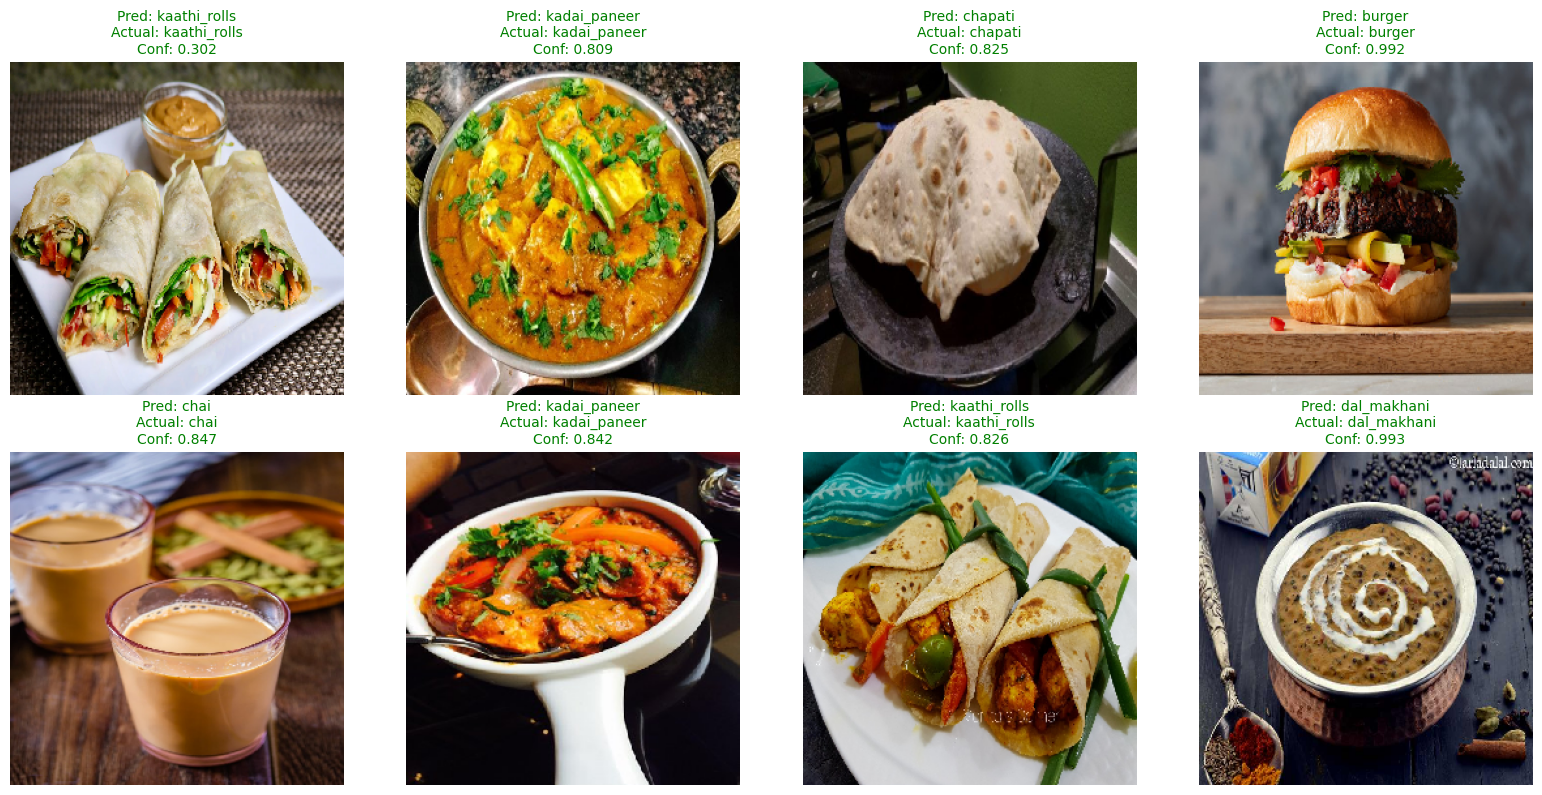


Detailed predictions:

Image 1:
  Predicted: kaathi_rolls (confidence: 0.3020)
  Actual: kaathi_rolls
  Correct: ✓
  Top 3 predictions:
    1. kaathi_rolls: 0.3020
    2. chole_bhature: 0.1463
    3. pav_bhaji: 0.0936

Image 2:
  Predicted: kadai_paneer (confidence: 0.8087)
  Actual: kadai_paneer
  Correct: ✓
  Top 3 predictions:
    1. kadai_paneer: 0.8087
    2. pav_bhaji: 0.1285
    3. dal_makhani: 0.0594

Image 3:
  Predicted: chapati (confidence: 0.8245)
  Actual: chapati
  Correct: ✓
  Top 3 predictions:
    1. chapati: 0.8245
    2. butter_naan: 0.0710
    3. kaathi_rolls: 0.0368

Image 4:
  Predicted: burger (confidence: 0.9924)
  Actual: burger
  Correct: ✓
  Top 3 predictions:
    1. burger: 0.9924
    2. pizza: 0.0055
    3. pav_bhaji: 0.0012

Image 5:
  Predicted: chai (confidence: 0.8474)
  Actual: chai
  Correct: ✓
  Top 3 predictions:
    1. chai: 0.8474
    2. burger: 0.1191
    3. kulfi: 0.0128


In [14]:
# Test the model on a few validation samples
print("\nTesting model predictions...")

# Get a batch of validation data
test_images, test_labels = next(validation_generator)

# Make predictions
predictions = best_model.predict(test_images, verbose=0)

# Display results for first 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(min(8, len(test_images))):
    # Get prediction
    predicted_class_idx = np.argmax(predictions[i])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[i][predicted_class_idx]
    
    # Get actual class
    actual_class_idx = np.argmax(test_labels[i])
    actual_class = class_names[actual_class_idx]
    
    # Display image
    axes[i].imshow(test_images[i])
    
    # Set title with prediction info
    color = 'green' if predicted_class_idx == actual_class_idx else 'red'
    axes[i].set_title(f'Pred: {predicted_class}\nActual: {actual_class}\nConf: {confidence:.3f}', 
                     color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print detailed predictions for first 5 images
print("\nDetailed predictions:")
for i in range(min(5, len(test_images))):
    predicted_class_idx = np.argmax(predictions[i])
    actual_class_idx = np.argmax(test_labels[i])
    confidence = predictions[i][predicted_class_idx]
    
    print(f"\nImage {i+1}:")
    print(f"  Predicted: {class_names[predicted_class_idx]} (confidence: {confidence:.4f})")
    print(f"  Actual: {class_names[actual_class_idx]}")
    print(f"  Correct: {'✓' if predicted_class_idx == actual_class_idx else '✗'}")
    
    # Show top 3 predictions
    top3_idx = np.argsort(predictions[i])[-3:][::-1]
    print("  Top 3 predictions:")
    for j, idx in enumerate(top3_idx):
        print(f"    {j+1}. {class_names[idx]}: {predictions[i][idx]:.4f}")


In [15]:
# Save the model with the EXACT name your backend expects
MODEL_SAVE_PATH = 'rawModelv1.h5'  # This matches your backend: model = tf.keras.models.load_model("rawModelv1.h5")

# Save the best model
try:
    # Use the best model (from checkpoint)
    best_model.save(MODEL_SAVE_PATH)
    print(f"✅ Model saved successfully as '{MODEL_SAVE_PATH}'")
    
    # Verify the saved model
    test_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print(f"✅ Model verification successful - can be loaded")
    
    # Test a prediction with the saved model
    test_pred = test_model.predict(test_images[:1], verbose=0)
    print(f"✅ Prediction test successful - output shape: {test_pred.shape}")
    
except Exception as e:
    print(f"❌ Error saving model: {e}")

# Also save a backup with timestamp
backup_name = f'food_model_backup_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'
try:
    best_model.save(backup_name)
    print(f"✅ Backup model saved as '{backup_name}'")
except Exception as e:
    print(f"❌ Error saving backup model: {e}")


✅ Model saved successfully as 'rawModelv1.h5'
✅ Model verification successful - can be loaded
✅ Prediction test successful - output shape: (1, 20)
✅ Backup model saved as 'food_model_backup_20250729_013914.h5'


In [16]:
print("\n" + "="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)

print(f"Model Architecture: CNN with {model.count_params():,} parameters")
print(f"Input Shape: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Training Samples: {train_generator.samples:,}")
print(f"Validation Samples: {validation_generator.samples:,}")
print(f"Training Duration: {training_duration}")

print(f"\nFinal Performance:")
print(f"  Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Top-5 Accuracy: {val_top5_acc:.4f} ({val_top5_acc*100:.2f}%)")

print(f"\nModel Files Created:")
print(f"  Main model: {MODEL_SAVE_PATH}")
print(f"  Best model: best_food_model.h5")
print(f"  Backup model: {backup_name}")
print(f"  Training log: training_log.csv")

print(f"\nClass Names (for backend):")
print(f"  {class_names}")

print("\n✅ Training completed successfully!")
print("Your model is now ready to use in the backend.")

# Expected results message
if val_accuracy > 0.7:
    print("🎉 Great! Your model achieved good accuracy (>70%)")
elif val_accuracy > 0.5:
    print("⚠️  Model accuracy is moderate (50-70%). Consider:")
    print("   - Adding more training data")
    print("   - Training for more epochs")
    print("   - Adjusting hyperparameters")
else:
    print("❌ Model accuracy is low (<50%). Please:")
    print("   - Check your dataset quality")
    print("   - Ensure proper class balance")
    print("   - Verify image preprocessing")

print("\n" + "="*60)



MODEL TRAINING SUMMARY
Model Architecture: CNN with 1,445,300 parameters
Input Shape: 256x256x3
Number of Classes: 20
Training Samples: 4,202
Validation Samples: 1,037
Training Duration: 5:42:23.234265

Final Performance:
  Validation Accuracy: 0.7607 (76.07%)
  Validation Loss: 0.7278
  Top-5 Accuracy: 0.9795 (97.95%)

Model Files Created:
  Main model: rawModelv1.h5
  Best model: best_food_model.h5
  Backup model: food_model_backup_20250729_013914.h5
  Training log: training_log.csv

Class Names (for backend):
  ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']

✅ Training completed successfully!
Your model is now ready to use in the backend.
🎉 Great! Your model achieved good accuracy (>70%)

